# Code for evaluateing the results of `run_simulation.py`

After having run multiple simulations with `run_simulation.py`, we evaluate the results using this notebook. We plot the coverage rate using both $CI_{\text{sampling}}$ and $CI_{\text{total}}$, expecting the first to undercover and the second to be accurate.

In [1]:
from glob import glob
import numpy as np
from tqdm import tqdm
from scipy.stats import norm
import pandas as pd
import json
import configparser
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

config = configparser.ConfigParser()
config.read('../config.ini')
DATA_DIR = config['PATHS']['DATA_DIR']

In [2]:
# Load the data
sigma_X = 5.0
result_files = glob(os.path.join(DATA_DIR, 'simulation_with_point_runs', f'run_*_sigmaX_{sigma_X}_*', 'results.json'))
ate_files = glob(os.path.join(DATA_DIR, 'simulation_with_point_runs', f'run_*_sigmaX_{sigma_X}_*', 'ate_estimates.npy'))
print(f'Found a total of {len(result_files)} experiment runs for sigma_X={sigma_X}')

Found a total of 974 experiment runs for sigma_X=5.0


Load results as a pandas dataframe.

In [3]:
results = []

for result_file in result_files:
    with open(result_file) as f:
        results.append(json.load(f))
        
res_df = pd.DataFrame(results)
res_df.describe()

,true_tau,n_train_samples,n_trial_samples,target_tau,r2_score,sigma_M,k,m,modeling_error,sampling_error,global_mean
count,974.0,974.0,974.0,974.000000,974.000000,974.0,974.000000,974.000000,974.000000,974.000000,974.000000
mean,0.2,60000.0,10000.0,0.201534,0.587589,5.0,0.708133,0.029134,0.021350,0.042202,0.200557
std,0.0,0.0,0.0,0.035468,0.009709,0.0,0.004270,0.006360,0.000340,0.003224,0.041860
min,0.2,60000.0,10000.0,0.069470,0.558158,5.0,0.691582,0.008477,0.020374,0.036049,0.025044
25%,0.2,60000.0,10000.0,0.177413,0.581240,5.0,0.705385,0.024544,0.021133,0.040618,0.172433
50%,0.2,60000.0,10000.0,0.201403,0.587811,5.0,0.708201,0.029247,0.021334,0.041840,0.200110
75%,0.2,60000.0,10000.0,0.225346,0.594516,5.0,0.710966,0.033419,0.021541,0.043198,0.228392
max,0.2,60000.0,10000.0,0.317280,0.616254,5.0,0.720636,0.049205,0.024599,0.108585,0.329911


Define function to check if the CIs encompass the true value.

In [4]:
def in_intervals(row, alpha=0.1):
    """
    Check if the true tau is within the confidence intervals

    Parameters:
    row (pd.Series) A row of the results dataframe representing one experiment.
    alpha (float) The significance level for the confidence interval.

    Returns:
    row (pd.Series) The row with two added columns:
        - in_sample_ci: 1 if the true tau is within the sampling error confidence interval, 0 otherwise.
        - in_sample_model_ci: 1 if the true tau is within the total error confidence interval, 0 otherwise.
    """

    true_tau = row['true_tau']
    modeling_error = row['modeling_error']
    sampling_error = row['sampling_error']
    global_mean = row['global_mean']
    z = norm.ppf((1 - alpha/2))
    
    # Confidence intervals
    ci_sampling_only = (global_mean - z * sampling_error, global_mean + z * sampling_error)
    total_error = np.sqrt(sampling_error**2 + modeling_error**2)
    ci_with_both_errors = (global_mean - z * total_error, global_mean + z * total_error)
    
    in_ci_sampling_only = ci_sampling_only[0] < true_tau and true_tau < ci_sampling_only[1]
    in_ci_with_both_errors = ci_with_both_errors[0] < true_tau and true_tau < ci_with_both_errors[1]
    
    row['in_sample_ci'] = float(in_ci_sampling_only)
    row['in_sample_model_ci'] = float(in_ci_with_both_errors)
    
    return row

Get covearge rate for values of $\alpha$ between 0 and 1.

In [5]:
in_sample_ci_coverage_for_alphas = []
in_sample_model_ci_coverage_for_alphas = []

alphas = np.linspace(0, 1, 50)
for alpha in tqdm(alphas):
    
    alpha_res_df = res_df.apply(lambda row: in_intervals(row, alpha=alpha), axis=1)
    
    in_sample_ci_coverage = alpha_res_df['in_sample_ci'].mean()
    in_sample_model_ci_coverage = alpha_res_df['in_sample_model_ci'].mean()

    in_sample_ci_coverage_for_alphas.append(in_sample_ci_coverage)
    in_sample_model_ci_coverage_for_alphas.append(in_sample_model_ci_coverage)

100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Plot intended vs empirical coverage rate.

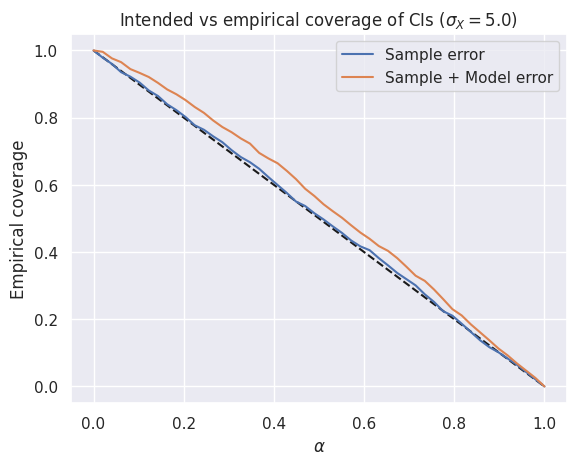

In [6]:
plt.plot([0, 1], [1, 0], linestyle='--', color='k')
plt.plot(alphas, in_sample_ci_coverage_for_alphas, label='Sample error')
plt.plot(alphas, in_sample_model_ci_coverage_for_alphas, label='Sample + Model error')
plt.xlabel(r'$\alpha$')
plt.ylabel('Empirical coverage')
plt.title(rf'Intended vs empirical coverage of CIs ($\sigma_X=${sigma_X})')
plt.legend()
plt.show()

Empirical coverage of $CI_{\text{sampling}_k}$ for different significance levels ($\alpha$) aligns well with the intended coverage. However, $CI_{\text{total}_k}$ appears too conservative, leading to over-coverage. We expected $CI_{\text{sampling}_k}$ to under-cover and $CI_{\text{total}_k}$ to be well calibrated.

# Using percentiles

We can do the same thing using percentiles instead of standard errors. However, the results look the same.

In [41]:
true_tau = 0.2

sample_coverage_matrix = []
sample_model_coverage_matrix = []

alphas = np.linspace(0, 1, 10)
for ate_file in tqdm(ate_files):
    
    ate_estimates = np.load(ate_file)
    row_means = np.mean(ate_estimates, axis=1)
    np.percentile(row_means, [2.5, 97.5])
    
    trial_sample_coverages = []
    trial_sample_model_coverages = []
    
    tau_est = np.mean(ate_estimates)
    row_means = np.mean(ate_estimates, axis=1)
    
    for alpha in alphas:
        percentiles = [100*alpha/2, 100*(1 - alpha/2)]
        
        sample_ci = np.percentile(row_means, percentiles)
        sample_model_ci = np.percentile(ate_estimates, percentiles)
        
        in_sample_ci = (sample_ci[0] < true_tau) and (true_tau < sample_ci[1])
        in_sample_model_ci = (sample_model_ci[0] < true_tau) and (true_tau < sample_model_ci[1])
        
        trial_sample_coverages.append(in_sample_ci)
        trial_sample_model_coverages.append(in_sample_model_ci)
        
    sample_coverage_matrix.append(trial_sample_coverages)
    sample_model_coverage_matrix.append(trial_sample_model_coverages)

100%|██████████| 992/992 [02:05<00:00,  7.89it/s]


In [47]:
sample_coverage_matrix = np.asarray(sample_coverage_matrix)
sample_model_coverage_matrix = np.asarray(sample_model_coverage_matrix)

In [52]:
coverage_for_alpha_in_sample_ci = sample_coverage_matrix.mean(axis=0)
coverage_for_alpha_in_sample_model_ci = sample_model_coverage_matrix.mean(axis=0)

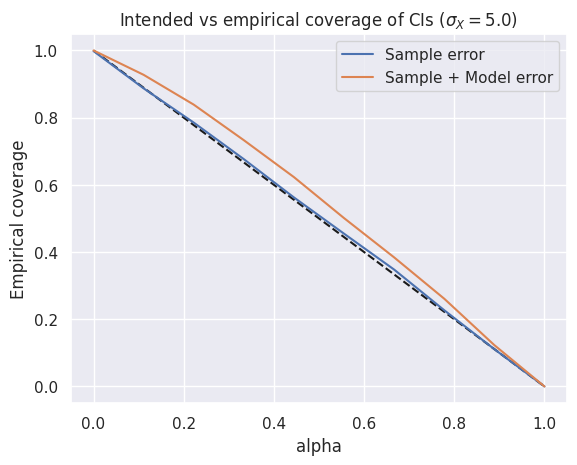

In [53]:
plt.plot([0, 1], [1, 0], linestyle='--', color='k')
plt.plot(alphas, coverage_for_alpha_in_sample_ci, label='Sample error')
plt.plot(alphas, coverage_for_alpha_in_sample_model_ci, label='Sample + Model error')
plt.xlabel('alpha')
plt.ylabel('Empirical coverage')
plt.title(rf'Intended vs empirical coverage of CIs ($\sigma_X=${sigma_X})')
plt.legend()
plt.show()